# Using ideas proposed in: *Contextual string embeddings for sequence labeling* (Abik et al., 2018)
[Source](https://github.com/zalandoresearch/flair)

### As ever, do not run this stuff without a GPU

In [1]:
import torch
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

GeForce RTX 2070
True


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))
from haberrspd.plotting import plot_roc_curve
from haberrspd.pdnet_flair import make_data_flair_readable, make_train_test_dev, character_RNN
from pathlib import Path
import pandas as pd
DATA_ROOT = Path("../data/") / "MJFF" / "preproc" # Note the relative path
DATA_ROOT_FASTTEXT = Path("../data/MJFF/fasttext/") # Note the relative path

# from flair.data_fetcher import NLPTaskDataFetcher, MultiCorpus
# from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
# from flair.models import TextClassifier
# from flair.trainers import ModelTrainer
# from flair.data import Sentence
from flair.training_utils import EvaluationMetric

## Things I would like to try with flair:

1. Combine English (MJFF and mechanical turk data) and Spanish embeddings
2. Do flair-embeddings + CNN like [this](https://github.com/huggingface/pytorch-pretrained-BERT/issues/129) (compare against ELMo and BERT)
3. Extend to MJFF English + MJFF Spanish + NeuroQwerty
4. Model optimisation (BO and various other options)
5. [Learning curves -- do them](https://www.deeplearning.ai/content/uploads/2018/09/Ng-MLY01-12.pdf)

## Train a Custom Text Binary Classifier [PD/HC]

Will re-write the classifer itself, which lives in **text_classification_model.py**

### Non-flair format

In [3]:
ls ../data/MJFF/preproc/

EnglishData-preprocessed.csv         SpanishData-preprocessed.csv
EnglishSpanishData-preprocessed.csv


In [4]:
# Note that shuffling happens att this
data = pd.read_csv(DATA_ROOT / "EnglishData-preprocessed.csv",encoding='utf-8-sig').sample(frac=1)

In [7]:
data.head(3)

,Patient_ID,Diagnosis,Sentence_ID,Preprocessed_typed_sentence
1062,6,1,55,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...
501,28,1,55,hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...
274,19,1,60,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...


In [8]:
data_flair =  make_data_flair_readable(data)

In [9]:
data_flair.head(3)

,label,text
1062,__label__1,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...
501,__label__1,hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...
274,__label__1,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...


In [11]:
data_flair.to_csv(DATA_ROOT_FASTTEXT / "EnglishData-preprocessed_fasttext_format.csv", 
            encoding='utf-8-sig', 
            index=False)

### Already in flair format

In [15]:
# Note that shuffling happens att this
data = pd.read_csv(DATA_ROOT_FASTTEXT / "spanish" /"preprocessed_SpanishData_fasttext_format.csv", encoding='utf-8-sig').sample(frac=1)

In [37]:
# Note that shuffling happens att this
language = "english"
data = pd.read_csv(DATA_ROOT_FASTTEXT / language /  "preprocessed_MechanicalTurkCombinedEnglishData_fasttext_format.csv", encoding='latin-1').sample(frac=1)

In [38]:
data.iloc[0:int(len(data)*0.8)].to_csv(DATA_ROOT_FASTTEXT / language /'train_w_mt.csv',sep='\t', index = False,
                                       header = False) # sep='\t'
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv(DATA_ROOT_FASTTEXT / language /'test_w_mt.csv',sep='\t',
                                                        index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv(DATA_ROOT_FASTTEXT / language / 'dev_w_mt.csv',sep='\t',
                                      index = False, header = False);
print(data.shape)
data.head()

(2604, 2)


,label,text
1201,__label__0,"Chinese cuisine in Springfield, Missouri is al..."
669,__label__0,The novel explores the relationship between Pa...
931,__label__0,"First, war must occur for a good and just purp..."
1399,__label__0,Many Dutch multinationals have their headquar...
1141,__label__0,The novel explores the relationship between Pa...


In [21]:
make_train_test_dev(data_flair, ',', '/home/neil/cloud/habitual_errors_NLP/data/MJFF/fasttext/english/')

---

### Param optimisation

In [4]:
from haberrspd.pdnet_flair import optimise_mjff_english_only

In [ ]:
optimise_mjff_english_only()

---

In [14]:
from flair.embeddings import CharacterEmbeddings, OneHotEmbeddings
from flair.data import Sentence

In [ ]:
# init embedding
# embedding = CharacterEmbeddings()
embedding = OneHotEmbeddings(embedding_length=50)

# create a sentence
sentence = Sentence('The grass is green .')

# embed words in sentence
embedding.embed(sentence)

In [13]:
embedding.char_embedding_dim

25

### Training a Custom Text Classification Model

In [3]:
# Instance to control parameter settings of model
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)

    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    
    # Model
    rnn_layers = 1,
    reproject_words = True,
    reproject_words_dimension = None,
    bidirectional=False,
    dropout=0.5,
    word_dropout=0.,
    locked_dropout=0.,
    hidden_size=32,
    rnn_type = 'LSTM',
    
    # Training params
    testing=True,
    evaluation_metric = EvaluationMetric.MICRO_F1_SCORE, # will change to cosine loss
    mini_batch_size = 16,
    learning_rate=1e-2,
    patience=3,
    max_epochs=10,
)

## Train model


In [ ]:
character_RNN(config)

## Use model for prediction

In [45]:
test_data = pd.read_csv(DATA_ROOT_FASTTEXT / "english" /  "test_w_mt.csv", sep='\t',header=None)
classifier = TextClassifier.load_from_file(DATA_ROOT_FASTTEXT / "english" / 'best-model.pt')

2019-04-09 14:33:37,833 loading file ../data/MJFF/fasttext/english/best-model.pt


In [50]:
test_data = pd.read_csv(DATA_ROOT_FASTTEXT / "english" /  "test.csv", sep='\t',header=None)
classifier = TextClassifier.load_from_file(DATA_ROOT_FASTTEXT / "english" / 'best-model.pt')

2019-04-09 14:37:43,946 loading file ../data/MJFF/fasttext/english/best-model.pt


In [18]:
test_data = pd.read_csv(DATA_ROOT_FASTTEXT / "spanish" /  "test.csv", sep='\t',header=None)
classifier = TextClassifier.load_from_file(DATA_ROOT_FASTTEXT / "spanish" / 'best-model.pt')

2019-04-09 12:22:18,986 loading file ../data/MJFF/fasttext/spanish/best-model.pt


In [51]:
predicted_labels = [] # Predicted PD/HC under model
predicted_labels_probs = [] # Predicted PD/HC probability under model
for sent in test_data[1]:
    sentence = Sentence(sent)
    classifier.predict(sentence)
    for label in sentence.labels:
        predicted_labels.extend(label.value)
        predicted_labels_probs.append(label.score)

In [ ]:
from flair.visual.training_curves import Plotter
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plotter = Plotter()
plotter.plot_training_curves(DATA_ROOT_FASTTEXT / "spanish" / 'loss.tsv')
plotter.plot_weights(DATA_ROOT_FASTTEXT / "spanish" / 'weights.txt')

In [52]:
plot_roc_curve(test_data[0],predicted_labels_probs,False)

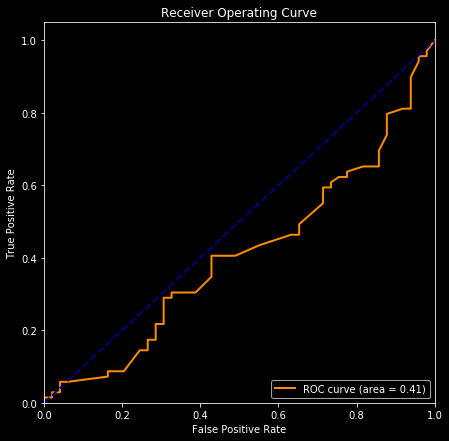